#<u>Задание 2</u>

Есть таблица с экспрессиями (название образца обычно начинается с SRR или ERR) для образцов сортированных клеток. В этой таблице экспрессии ряда генов для каждого образца. В таблице только некоторые гены, чтобы она была небольшой (обычно бывает 20 - 40 тыс разных генов). Ещё есть аннотация, в которой указано, какому типу клеток соответствует образец (колонка general_cell_type, каждый SRR соответствует определённому типу клеток, T_cells, NK_cells и т. д.). Необходимо, опираясь на эту аннотацию, сделать смеси из экспрессий этих клеток. Для каждой смеси выбирается случайный образец каждого типа клеток. Затем экспрессии этих образцов смешиваются в случайных соотношениях, например 0.1*CD4_T_cells + 0.2*B_cells  +... = mix_1. Смесь делается при помощи линейной комбинации векторов экспрессий. Сумма этих коэффициентов (долей клеток) перед векторами должна быть равна 1, коэффициенты должны быть случайными числами. CD4_T_cells в формуле обозначает вектор экспрессий определённого образца данного типа клеток, например, SRR1028230. Для каждой смеси используется разный набор образцов, но все типы клеток.
Таких смесей сделать необходимо сделать 1000 штук. Для каждой из этих смесей в отдельной таблице сохранить те доли клеток, которые туда замешивались.

Затем необходимо построить таблицу корреляций каждого гена с замешанным количеством клеток для каждого типа клеток по смесям. В итоговой таблице индексы – названия генов, колонки - типы клеток, на пересечении величины коэффициентов корреляции Пирсона.  Дополнительно можно визуализировать данную таблицу с помощью heatmap или clustermap.

Если в начальном варианте получится, что редко встречаются доли клеток в 70% и более, то необходимо написать такую генерацию распределений долей клеток, чтобы каждого типа клеток в смесях присутствовало от нуля до 100%

Задание необходимо оформить в виде кода в jupyter notebook на языке python.
Дополнительный пункт задания: обучить линейные модели, вычисляющие долю каждого типа клеток по экспрессиям смеси. Для моделей выбрать оптимальный набор генов из представленных и выбрать оптимальные параметры регуляризации. Обосновать набор параметров и генов. 
Второй дополнительный пункт задания: обучить нелинейные модели для этого (например, Random Forest). Для моделей выбрать оптимальный набор генов из представленных и выбрать оптимальные гиперпараметры обучения. Обосновать набор параметров и генов. 

---

# Чтение данных

In [2]:
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install --upgrade scipy
!pip install --upgrade seaborn
!pip install --upgrade plotly

Requirement already up-to-date: pandas in /usr/local/lib/python3.7/dist-packages (1.2.4)
Requirement already up-to-date: numpy in /usr/local/lib/python3.7/dist-packages (1.20.3)
Requirement already up-to-date: scipy in /usr/local/lib/python3.7/dist-packages (1.6.3)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.7/dist-packages (0.11.1)
Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


Подключаем требуемые билблиотеки:

In [96]:
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr   
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib as plt

Считываем два входных набора данных:


*   `annotation` - содержит информацию об образцах (тип клеток, количество);
*   `cell_expr` - содержит информацию об экспрессиях генов по всем образцам.



In [4]:
annotation = pd.read_csv("Annotation.txt", sep = "\t")
cell_expr = pd.read_csv("cells_expressions.tsv", sep = "\t", index_col=0)

annotation.columns = ['sample_id', 'cell_type', 'est_counts', 'material_type']
cell_expr=cell_expr.rename(columns = {'Unnamed: 0':'gene'})

In [5]:
cell_types = annotation.cell_type.nunique(); print("Уникальных типов клеток: " + str(cell_types))
gene_numbers = cell_expr.index.nunique(); print("Уникальных генов: " + str(gene_numbers))
sample_n = annotation.shape[0]; print("Образцов: " + str(sample_n))

Уникальных типов клеток: 11
Уникальных генов: 114
Образцов: 590


In [6]:
annotation

,sample_id,cell_type,est_counts,material_type
0,ERR1197864,Macrophages,36772300,polyA RNA
1,ERR1197865,Macrophages,32080500,polyA RNA
2,ERR1197866,Macrophages,37266700,polyA RNA
3,ERR1197867,Macrophages,29086100,polyA RNA
4,ERR1197868,Macrophages,29902700,polyA RNA
...,...,...,...,...
585,SRR5048168,B_cells,11236600,polyA RNA
586,SRR773858,Endothelium,6424180,NaN
587,SRR773859,Endothelium,5790500,NaN
588,SRR773860,Endothelium,6995560,NaN


In [7]:
cell_expr

,ERR1197864,ERR1197865,ERR1197866,ERR1197867,ERR1197868,ERR1197869,ERR1197870,ERR1197872,ERR1197873,ERR1197874,ERR1197875,ERR1197876,ERR1377116,ERR1377117,ERR1377118,ERR1377119,ERR1377120,ERR1377122,ERR1377123,ERR1377124,ERR1377125,ERR1377126,ERR1377127,ERR1377128,ERR1377129,ERR1377130,ERR1377131,ERR1377132,ERR1377133,ERR1377134,ERR1377135,ERR1377136,ERR1377137,ERR1377138,ERR1377139,ERR1377140,ERR1377141,ERR1377142,ERR1377143,ERR1377144,...,SRR1363150,SRR1363151,SRR3647474,SRR3647475,SRR3647476,SRR3647477,SRR3647488,SRR3647489,SRR3647490,SRR3647491,SRR1038582,SRR1693245,SRR3192382,SRR3192383,SRR3192467,SRR3192468,SRR3192492,SRR3192493,SRR3192497,SRR3192498,SRR3192502,SRR3192503,SRR3192539,SRR3192540,SRR3192659,SRR3192660,SRR3192661,SRR3192662,SRR5048113,SRR5048114,SRR5048163,SRR5048164,SRR5048165,SRR5048166,SRR5048167,SRR5048168,SRR773858,SRR773859,SRR773860,SRR773861
FLT1,2.536820,11.425313,3.601080,11.109491,4.982133,8.697796,6.568391,1.074461,1.035550,0.878704,1.638196,1.117106,6.020460,2.425593,0.262797,1.046640,35.416107,3.540281,6.434759,4.924504,0.923947,1.806129,2.124611,1.557767,0.441455,1.505347,1.259029,12.210421,4.483710,3.856591,2.925053,0.634269,0.678126,6.880730,0.700072,3.079668,1.427050,0.510684,0.325313,0.423197,...,0.252798,0.349280,0.815823,0.738328,0.277811,0.257552,1.138646,0.912619,0.321066,0.378595,0.461951,24.720093,0.142371,0.222398,2.036624,1.895071,1.603177,2.327223,1.157427,2.040043,0.320548,0.479198,0.445478,0.504327,0.947236,1.183712,3.585713,1.442718,24.775983,24.787324,1.310898,1.545111,0.697061,1.942876,2.141574,1.687968,1.820712,2.473897,22.942158,89.352816
PTGS1,5.393487,18.208523,22.334430,15.774290,9.338110,14.406180,27.177143,2.117940,1.043153,0.509105,0.154497,0.891916,46.411208,27.073434,14.148977,31.942467,14.607666,23.117144,85.179989,17.625748,52.015313,10.032418,94.394410,26.550907,20.504952,57.237874,12.961861,50.290555,169.206720,324.141730,100.243008,4.756697,3.314532,115.085927,45.669016,32.541614,18.507129,31.179390,14.531809,14.081167,...,27.729720,15.470337,13.506652,15.640939,0.397227,0.564910,14.059605,14.578916,0.419401,0.554602,0.877314,424.904710,0.892062,1.742892,73.328969,66.935467,50.617232,86.027589,23.947522,24.559896,17.898421,28.418233,11.456640,17.785235,59.797599,1.805842,3.321714,0.897006,19.275917,24.262849,3.796830,3.592222,3.492352,5.161744,4.811197,5.622911,0.526527,0.350217,4.511513,46.693722
CD40LG,0.208795,0.215572,0.156339,0.206512,0.547463,0.504233,0.148545,5.818134,17.637870,5.413817,34.381200,4.648149,0.017626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010701,0.014776,0.000000,0.042306,0.000000,0.000000,0.016823,0.000180,0.000000,0.009157,0.006877,0.005312,0.013298,0.000255,0.012169,0.000000,0.000000,0.006529,0.006253,0.000000,...,0.563920,0.380028,1.997180,0.122481,35.368682,6.599987,1.978560,0.070633,35.124810,7.422354,1.499868,0.000000,0.018406,0.028693,0.030875,0.000000,0.029697,0.044418,0.446129,1.016900,0.000000,0.068010,0.174534,0.129945,0.212446,0.145463,0.024145,0.024105,0.767240,0.686592,0.000042,0.113521,0.000000,0.268954,0.337554,0.244120,0.000000,0.000000,0.000000,0.000000
VEGFC,0.067044,0.119804,0.010536,0.065166,0.000000,0.115518,6.394040,0.165600,0.011409,0.007398,0.114393,0.045945,42.417000,47.146600,48.563700,56.436300,70.913100,41.029300,53.635700,53.633200,60.783300,65.798100,101.267000,50.296600,59.608200,146.790000,52.220700,58.136300,108.866000,131.924000,89.115400,44.738500,33.400500,38.965500,44.251500,73.482000,62.679200,45.828100,38.284900,60.114700,...,0.000000,0.000000,0.000000,0.012518,0.000000,0.000000,0.000000,0.057716,0.000000,0.000000,0.000000,18.600700,4.549540,7.347630,24.944100,23.571300,87.720100,65.953200,11.885000,13.542800,13.731900,12.791400,6.770220,5.409890,17.474700,6.677010,3.166230,7.487340,23.141700,28.709000,0.000000,0.000000,0.000000,0.021979,0.000000,0.021334,23.441300,28.918300,15.330600,78.833000
TBX21,0.118556,0.188314,0.024841,0.266320,1.056980,0.474117,0.713328,7.158190,8.7

# Препроцессинг данных

Создадим таблицу, в которой будем хранить векторы коэффициентов смесей. Каждый вектор случаен и имеет длину `cell_types`, причем его сумма равна 1.

In [8]:
coeffs_table = []
for _ in range(1000):
    coeff = np.array([np.random.random() for i in range(cell_types)])
    coeff = coeff / sum(coeff)
    coeffs_table.append(coeff)

Проверим, что сумма внутри каждого вектора равна единице:

In [9]:
print([round(sum(x), 3) for x in coeffs_table] == [1 for x in coeffs_table])

True


Создадим таблицу `counts_table`, в которой будем хранить информацию о смесях. В каждом случае выбираем для каждого типа клетки случайных образец. Далее, поэлементно перемножаем количество клеток конкретного образца с соответствующим вектором коэффициентов с последующим округлением до целого числа.

In [10]:
counts_table = pd.DataFrame(columns = ["sample_id", "cell_type", "est_counts", "material_type", "mix_num"])
for i in range(1000):
    mix_annot = annotation.groupby('cell_type').apply(lambda x: x.sample(1)).reset_index(drop=True)
    mix_annot["est_counts"] = (mix_annot["est_counts"] * coeffs_table[i]).astype(int)
    mix_annot["mix_num"] = i
    counts_table = counts_table.append(mix_annot)

In [11]:
counts_table

,sample_id,cell_type,est_counts,material_type,mix_num
0,SRR1812734,B_cells,456418,polyA RNA,0
1,SRR3322295,CAF_associated,8694843,polyA RNA,0
2,SRR3185801,CD4_T_cells,245721,polyA RNA,0
3,SRR1551037,CD8_T_cells,1829792,total RNA,0
4,SRR2919777,DC,1008129,total RNA,0
...,...,...,...,...,...
6,SRR1022963,Granulocytes,1131501,total RNA,999
7,ERR688002,Macrophages,927759,NaN,999
8,SRR1551034,Monocytes,1578352,total RNA,999
9,SRR1551080,NK_cells,1372115,total RNA,999


Создадим таблицу с информацией об экспрессиях генов в каждой смеси. Каждая смесь получается как линейная комбинация векторов экспрессий генов каждого образца с соответствующим количеством клеток образца для этой смеси.

In [12]:
mix_table = pd.DataFrame(columns = ["gene_expr", "mix_num"])
for i in range(1000):
    cell_expr_subset = cell_expr[counts_table[counts_table["mix_num"] == i]["sample_id"]]
    new_mix = cell_expr_subset.dot(coeffs_table[i]).to_frame()
    new_mix["mix_num"] = i
    new_mix.columns = ["gene_expr", "mix_num"]
    mix_table = mix_table.append(new_mix)

mix_table["gene"] = mix_table.index
mix_table = mix_table.reset_index(drop=True)

In [13]:
mix_table

,gene_expr,mix_num,gene
0,7.274620,0,FLT1
1,24.491615,0,PTGS1
2,5.448041,0,CD40LG
3,25.085969,0,VEGFC
4,16.209770,0,TBX21
...,...,...,...
113995,0.296143,999,MMP7
113996,146.779788,999,CD79A
113997,430.228665,999,COL6A2
113998,20.543218,999,FAP


# Создание корреляционной матрицы

Создадим матрицу `mix_table_mat`, в которой строки будут соответствовать экспрессиям генов, а столбцы - смесям:

In [ ]:
mix_table_gb = mix_table.groupby('gene')[['gene_expr']]
mix_table_mat = np.array([mix_table_gb.get_group(x).astype(float) for x in mix_table_gb.groups], dtype='float')

Создадим матрицу, в которой строки будут соответствовать типам клеток, а столбцы - смесям:

In [ ]:
counts_table_gb = counts_table.groupby('cell_type')[["est_counts"]]
counts_table_mat = np.array([counts_table_gb.get_group(x).astype(float)  for x in counts_table_gb.groups], dtype='float')

Получили две матрицы верных размерностей:

In [17]:
print(mix_table_mat.shape)
print(counts_table_mat.shape)

(114, 1000, 1)
(11, 1000, 1)


In [18]:
counts_table_mat.shape

(11, 1000, 1)

Создадим требуемую матрицу корреляций. Для этого будем поэлементно заполнять матрицу c `gene_numbers` количесвтом строк и `cell_types` количеством столбцов. Кроме того, отбрасываем индексы, по которым хотя бы в одном из случаев будут пропущенные значения.

In [19]:
corr_mat = np.zeros((gene_numbers, cell_types))

for i in range(gene_numbers):
 for j in range(cell_types):
   a = mix_table_mat[i, :].flatten()
   b = counts_table_mat[j, :].flatten()
   good = ~np.logical_or(np.isnan(a), np.isnan(b))
   corr_mat[i, j] = pearsonr(a[good], b[good])[0]

corr_table = pd.DataFrame(data = corr_mat,
                          index = mix_table_gb.groups.keys(),
                          columns = counts_table_gb.groups.keys())
corr_table

,B_cells,CAF_associated,CD4_T_cells,CD8_T_cells,DC,Endothelium,Granulocytes,Macrophages,Monocytes,NK_cells,Neutrophils
ACTA2,-0.013531,0.269686,-0.043680,-0.013095,-0.060927,0.058087,-0.087759,-0.009713,-0.092569,-0.045181,-0.014931
ANGPT2,-0.054999,-0.035105,-0.103190,-0.084084,0.037774,0.539838,-0.069408,-0.014686,-0.095655,-0.033459,-0.070672
APOC1,-0.031458,-0.009540,0.039511,-0.005239,-0.042866,-0.007695,-0.032159,0.192354,0.027223,-0.057952,-0.019928
ARG1,0.017146,-0.046585,-0.014158,-0.013557,-0.021642,-0.030146,0.129366,-0.048006,-0.034427,-0.085836,0.112110
BLK,0.411489,-0.056978,-0.062221,0.009121,-0.106167,-0.050944,-0.076145,-0.047393,-0.011713,-0.056356,-0.018130
...,...,...,...,...,...,...,...,...,...,...,...
VEGFC,-0.034407,0.211335,-0.057653,-0.054084,-0.078337,0.119826,-0.073189,-0.031976,-0.015268,-0.016231,-0.018127
VSIG4,-0.127588,0.012760,0.052937,-0.036031,0.018363,-0.038571,-0.001533,0.199068,-0.060847,-0.024746,-0.104908
VWF,-0.064986,0.000161,-0.110929,-0.060032,0.037570,0.843230,-0.092315,-0.036301,-0.107801,-0.036175,-0.095424
ZAP70,-0.086931,-0.041458,-0.008720,0.255936,-0.065438,-0.074012,-0.069854,-0.024528,-0.028471,-0.003533,-0.074923


# Визуализация корреляционной матрицы

Построим heatmap и clustermap полученной корреляционной матрицы:

In [85]:
fig = go.Figure(data=go.Heatmap(
                    x = list(counts_table_gb.groups.keys()),
                    y = list(mix_table_gb.groups.keys()),
                    z = corr_table,
                    colorbar = {"title": "Коэффициент корреляции Пирсона"})
                )
fig.update_layout(
    title="Heatmap корреляционной матрицы смесей по типам клеток по генам по всем смесям",
    xaxis_title="Тип клетки",
    yaxis_title="Ген",
    width = 800,
    height = 800
)


fig.show()

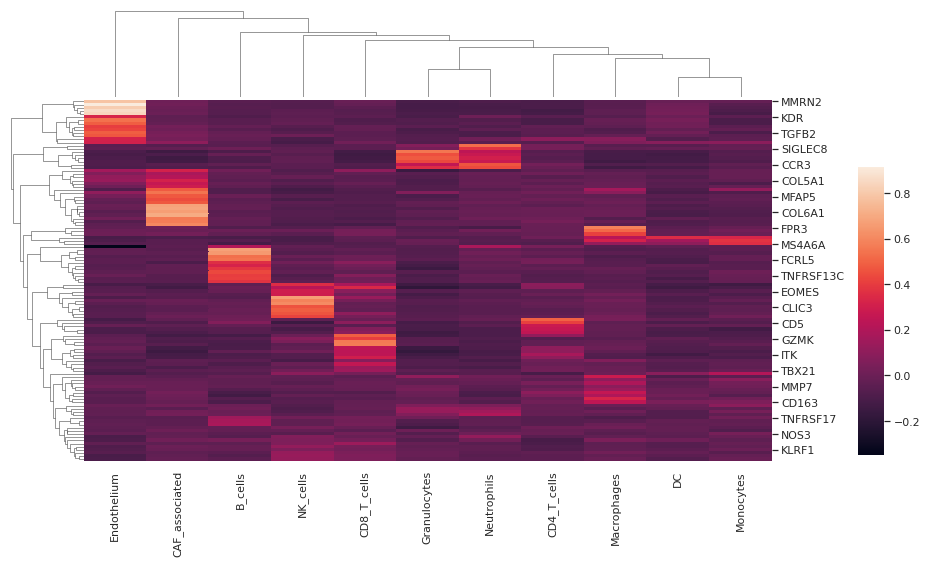

In [101]:
fig2 = sns.clustermap(corr_table,
                   figsize=(12, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(1, .2, .03, .5))

---
---